In [2]:
# Setup and Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import pickle
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import lightgbm as lgb
import warnings
warnings.filterwarnings('ignore')

# Paths
PROCESSED_DATA_PATH = Path("../data/processed")
SPLITS_PATH = Path("../data/splits")
CHECKPOINTS_PATH = Path("../checkpoints")
LOGS_PATH = Path("../logs")
PREDICTIONS_PATH = Path("../predictions")
VIZ_PATH = Path("../visualizations")

# Create directories
for path in [SPLITS_PATH, CHECKPOINTS_PATH, LOGS_PATH, PREDICTIONS_PATH]:
    path.mkdir(exist_ok=True, parents=True)

print("✅ Setup complete")

✅ Setup complete


In [3]:
# Load All Processed Features
import glob
from tqdm import tqdm

print("=" * 80)
print("LOADING ALL WEEKS")
print("=" * 80)

# Get all feature files
feature_files = sorted(glob.glob(str(PROCESSED_DATA_PATH / "features_w*.parquet")))
print(f"Found {len(feature_files)} feature files")

# Load all weeks
all_features = []
for file in tqdm(feature_files, desc="Loading weeks"):
    week_df = pd.read_parquet(file)
    week_num = file.split('_w')[-1].split('.')[0]
    week_df['week'] = int(week_num)  # Add week identifier
    all_features.append(week_df)

# Concatenate all weeks
features_df = pd.concat(all_features, ignore_index=True)

print(f"\n✅ Loaded all features")
print(f"Total shape: {features_df.shape}")
print(f"Weeks: {sorted(features_df['week'].unique())}")
print(f"Unique games: {features_df['game_id'].nunique()}")
print(f"Unique plays: {features_df[['game_id', 'play_id']].drop_duplicates().shape[0]}")
print(f"Total players: {features_df['nfl_id'].nunique()}")

LOADING ALL WEEKS
Found 18 feature files


Loading weeks: 100%|██████████| 18/18 [00:04<00:00,  4.26it/s]



✅ Loaded all features
Total shape: (4880579, 94)
Weeks: [np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8), np.int64(9), np.int64(10), np.int64(11), np.int64(12), np.int64(13), np.int64(14), np.int64(15), np.int64(16), np.int64(17), np.int64(18)]
Unique games: 272
Unique plays: 14108
Total players: 1384


In [4]:
# Load All Output Data
print("=" * 80)
print("LOADING ALL OUTPUT DATA")
print("=" * 80)

# Get all output files
output_files = sorted(glob.glob("../data/raw/output_2023_w*.csv"))
print(f"Found {len(output_files)} output files")

# Load all weeks
all_outputs = []
for file in tqdm(output_files, desc="Loading outputs"):
    week_df = pd.read_csv(file)
    week_num = file.split('_w')[-1].split('.')[0]
    week_df['week'] = int(week_num)
    all_outputs.append(week_df)

# Concatenate
output_df = pd.concat(all_outputs, ignore_index=True)

print(f"\n✅ Loaded all outputs")
print(f"Total shape: {output_df.shape}")
print(f"Unique players to predict: {output_df[['game_id', 'play_id', 'nfl_id']].drop_duplicates().shape[0]}")

LOADING ALL OUTPUT DATA
Found 18 output files


Loading outputs: 100%|██████████| 18/18 [00:00<00:00, 47.88it/s]



✅ Loaded all outputs
Total shape: (562936, 7)
Unique players to predict: 46045


In [5]:
# Prepare Data for Modeling
def prepare_modeling_data(features_df, output_df):
    """
    Prepare features and targets for modeling
    
    Strategy: For each player marked as player_to_predict=True,
    use the last frame of input as features to predict all output frames
    """
    
    # Get players to predict
    players_to_predict = features_df[features_df['player_to_predict'] == True]
    
    # Get last input frame for each player
    last_frames = players_to_predict.groupby(['game_id', 'play_id', 'nfl_id']).apply(
        lambda x: x.loc[x['frame_id'].idxmax()]
    ).reset_index(drop=True)
    
    print(f"Players to predict: {len(last_frames)}")
    
    # Define feature columns (exclude identifiers and targets)
    exclude_cols = [
        'game_id', 'play_id', 'nfl_id', 'frame_id', 'player_to_predict',
        'player_name', 'player_birth_date', 'player_height', 'player_weight',
        'game_date', 'game_time_eastern', 'home_team_abbr', 'visitor_team_abbr',
        'play_description', 'game_clock', 'yardline_side', 'possession_team',
        'defensive_team', 'pass_result', 'offense_formation', 'route_of_targeted_receiver',
        'dropback_type', 'pass_location_type', 'team_coverage_man_zone', 'team_coverage_type',
        'player_position', 'player_side', 'player_role', 'play_direction',
        'num_frames_output', 'ball_land_x', 'ball_land_y'
    ]
    
    feature_cols = [col for col in last_frames.columns if col not in exclude_cols]
    
    # Remove any remaining non-numeric columns
    feature_cols = [col for col in feature_cols if last_frames[col].dtype in ['int64', 'float64']]
    
    X = last_frames[['game_id', 'play_id', 'nfl_id'] + feature_cols].copy()
    
    # Handle missing values
    X[feature_cols] = X[feature_cols].fillna(X[feature_cols].median())
    
    # Create targets: flatten all output positions into a single vector per player
    # Target format: [x1, y1, x2, y2, ..., xN, yN] where N = num_frames_output
    
    targets = []
    valid_indices = []
    
    for idx, row in last_frames.iterrows():
        player_output = output_df[
            (output_df['game_id'] == row['game_id']) &
            (output_df['play_id'] == row['play_id']) &
            (output_df['nfl_id'] == row['nfl_id'])
        ].sort_values('frame_id')
        
        if len(player_output) > 0:
            # Flatten x, y positions
            positions = player_output[['x', 'y']].values.flatten()
            targets.append(positions)
            valid_indices.append(idx)
    
    # Filter X to only valid indices
    X = X.loc[valid_indices].reset_index(drop=True)
    
    # Pad targets to same length (max output frames)
    max_frames = max(len(t) for t in targets)
    targets_padded = np.array([
        np.pad(t, (0, max_frames - len(t)), constant_values=np.nan) 
        for t in targets
    ])
    
    y = pd.DataFrame(targets_padded)
    
    print(f"\nFeature matrix shape: {X.shape}")
    print(f"Target matrix shape: {y.shape}")
    print(f"Number of feature columns: {len(feature_cols)}")
    
    return X, y, feature_cols

X, y, feature_cols = prepare_modeling_data(features_df, output_df)

print(f"\n✅ Data prepared for modeling")
print(f"Feature matrix: {X.shape}")
print(f"Target matrix: {y.shape}")
print(f"Number of features: {len(feature_cols)}")

Players to predict: 46045

Feature matrix shape: (46045, 62)
Target matrix shape: (46045, 188)
Number of feature columns: 59

✅ Data prepared for modeling
Feature matrix: (46045, 62)
Target matrix: (46045, 188)
Number of features: 59


In [6]:
# Train/Val/Test Split - TEMPORAL SPLIT BY WEEK
print("=" * 80)
print("TRAIN/VAL/TEST SPLIT - TEMPORAL")
print("=" * 80)

# Strategy: Use early weeks for training, middle for validation, late for testing
# This simulates real-world scenario where we predict future games

# Define split
train_weeks = list(range(1, 13))   # Weeks 1-12 (67% of data)
val_weeks = list(range(13, 16))    # Weeks 13-15 (17% of data)
test_weeks = list(range(16, 19))   # Weeks 16-18 (16% of data)

print(f"Train weeks: {train_weeks}")
print(f"Val weeks: {val_weeks}")
print(f"Test weeks: {test_weeks}")

# Create masks based on week
train_mask = X['week'].isin(train_weeks)
val_mask = X['week'].isin(val_weeks)
test_mask = X['week'].isin(test_weeks)

# Split data
X_train = X[train_mask].reset_index(drop=True)
y_train = y[train_mask].reset_index(drop=True)

X_val = X[val_mask].reset_index(drop=True)
y_val = y[val_mask].reset_index(drop=True)

X_test = X[test_mask].reset_index(drop=True)
y_test = y[test_mask].reset_index(drop=True)

print(f"\n✅ Split complete")
print(f"Train: {len(X_train):,} samples ({len(X_train)/len(X)*100:.1f}%)")
print(f"  - Weeks: {sorted(X_train['week'].unique())}")
print(f"  - Games: {X_train['game_id'].nunique()}")
print(f"  - Plays: {X_train[['game_id', 'play_id']].drop_duplicates().shape[0]:,}")

print(f"\nVal:   {len(X_val):,} samples ({len(X_val)/len(X)*100:.1f}%)")
print(f"  - Weeks: {sorted(X_val['week'].unique())}")
print(f"  - Games: {X_val['game_id'].nunique()}")
print(f"  - Plays: {X_val[['game_id', 'play_id']].drop_duplicates().shape[0]:,}")

print(f"\nTest:  {len(X_test):,} samples ({len(X_test)/len(X)*100:.1f}%)")
print(f"  - Weeks: {sorted(X_test['week'].unique())}")
print(f"  - Games: {X_test['game_id'].nunique()}")
print(f"  - Plays: {X_test[['game_id', 'play_id']].drop_duplicates().shape[0]:,}")

# Save splits
X_train.to_parquet(SPLITS_PATH / "X_train.parquet", index=False)
y_train.to_parquet(SPLITS_PATH / "y_train.parquet", index=False)
X_val.to_parquet(SPLITS_PATH / "X_val.parquet", index=False)
y_val.to_parquet(SPLITS_PATH / "y_val.parquet", index=False)
X_test.to_parquet(SPLITS_PATH / "X_test.parquet", index=False)
y_test.to_parquet(SPLITS_PATH / "y_test.parquet", index=False)

with open(SPLITS_PATH / "feature_cols.pkl", "wb") as f:
    pickle.dump(feature_cols, f)

# Save split configuration
split_config = {
    'train_weeks': train_weeks,
    'val_weeks': val_weeks,
    'test_weeks': test_weeks,
    'split_type': 'temporal'
}
with open(SPLITS_PATH / "split_config.pkl", "wb") as f:
    pickle.dump(split_config, f)

print(f"\n✅ Splits saved to: {SPLITS_PATH}")

TRAIN/VAL/TEST SPLIT - TEMPORAL
Train weeks: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]
Val weeks: [13, 14, 15]
Test weeks: [16, 17, 18]

✅ Split complete
Train: 30,616 samples (66.5%)
  - Weeks: [np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8), np.int64(9), np.int64(10), np.int64(11), np.int64(12)]
  - Games: 180
  - Plays: 9,400

Val:   7,464 samples (16.2%)
  - Weeks: [np.int64(13), np.int64(14), np.int64(15)]
  - Games: 44
  - Plays: 2,253

Test:  7,965 samples (17.3%)
  - Weeks: [np.int64(16), np.int64(17), np.int64(18)]
  - Games: 48
  - Plays: 2,455

✅ Splits saved to: ..\data\splits


In [7]:
# Feature Scaling
scaler = StandardScaler()

X_train_scaled = X_train.copy()
X_val_scaled = X_val.copy()
X_test_scaled = X_test.copy()

X_train_scaled[feature_cols] = scaler.fit_transform(X_train[feature_cols])
X_val_scaled[feature_cols] = scaler.transform(X_val[feature_cols])
X_test_scaled[feature_cols] = scaler.transform(X_test[feature_cols])

# Save scaler
with open(CHECKPOINTS_PATH / "scaler.pkl", "wb") as f:
    pickle.dump(scaler, f)

print("✅ Features scaled and scaler saved")

✅ Features scaled and scaler saved


In [ ]:
# Evaluation Metrics 
def calculate_metrics(y_true, y_pred):
    """
    Calculate RMSE, ADE, and FDE
    Handles DataFrames and numpy arrays with NaN values in both y_true and y_pred
    """
    
    # Convert to numpy
    if isinstance(y_true, pd.DataFrame):
        y_true = y_true.values
    if isinstance(y_pred, pd.DataFrame):
        y_pred = y_pred.values
    
    # Ensure same shape
    assert y_true.shape == y_pred.shape, \
        f"Shape mismatch: y_true {y_true.shape} vs y_pred {y_pred.shape}"
    
    # === RMSE: Coordinate-level metric ===
    # Flatten and remove NaN pairs (NaN in either y_true OR y_pred)
    y_true_flat = y_true.flatten()
    y_pred_flat = y_pred.flatten()
    
    valid_mask = ~np.isnan(y_true_flat) & ~np.isnan(y_pred_flat)
    y_true_valid = y_true_flat[valid_mask]
    y_pred_valid = y_pred_flat[valid_mask]
    
    if len(y_true_valid) > 0:
        rmse = np.sqrt(np.mean((y_true_valid - y_pred_valid)**2))
    else:
        rmse = np.nan
    
    # === ADE and FDE: Frame-level metrics ===
    n_samples, n_coords = y_true.shape
    n_frames = n_coords // 2
    
    ade_list = []
    fde_list = []
    
    for i in range(n_samples):
        # Get this sample's coordinates
        sample_true = y_true[i].reshape(n_frames, 2)
        sample_pred = y_pred[i].reshape(n_frames, 2)
        
        # Calculate displacement for each frame
        displacements = []
        for j in range(n_frames):
            # Check if both x and y are valid for this frame
            if not (np.isnan(sample_true[j]).any() or np.isnan(sample_pred[j]).any()):
                # Euclidean distance: sqrt((x_true - x_pred)^2 + (y_true - y_pred)^2)
                dist = np.sqrt(np.sum((sample_true[j] - sample_pred[j])**2))
                displacements.append(dist)
        
        if len(displacements) > 0:
            # ADE: average of all frame displacements for this sample
            ade_list.append(np.mean(displacements))
            # FDE: last frame displacement for this sample
            fde_list.append(displacements[-1])
    
    # Average across all samples
    ade = np.mean(ade_list) if len(ade_list) > 0 else np.nan
    fde = np.mean(fde_list) if len(fde_list) > 0 else np.nan
    
    return {
        'RMSE': rmse,
        'ADE': ade,
        'FDE': fde,
        'n_valid_coords': len(y_true_valid),
        'n_valid_samples': len(ade_list)
    }

print("=" * 80)
print("EVALUATION METRICS DEFINED")
print("=" * 80)

# Test with NaN values
print("\nTesting metrics function with NaN values...")
test_true = np.array([
    [1.0, 2.0, 3.0, 4.0],
    [5.0, 6.0, np.nan, np.nan],  # Some NaN in true
    [9.0, 10.0, 11.0, 12.0]
])
test_pred = np.array([
    [1.1, 2.1, 3.1, 4.1],
    [5.1, 6.1, 7.1, 8.1],
    [np.nan, np.nan, 11.1, 12.1]  # Some NaN in pred
])

test_metrics = calculate_metrics(test_true, test_pred)

print(f"✅ Test RMSE: {test_metrics['RMSE']:.4f}")
print(f"✅ Test ADE: {test_metrics['ADE']:.4f}")
print(f"✅ Test FDE: {test_metrics['FDE']:.4f}")
print(f"✅ Valid coordinates: {test_metrics['n_valid_coords']}")
print(f"✅ Valid samples: {test_metrics['n_valid_samples']}")

print("\n✅ Evaluation metrics ready (handles NaN in predictions)")

EVALUATION METRICS DEFINED (ROBUST VERSION)

Testing metrics function with NaN values...
✅ Test RMSE: 0.1000
✅ Test ADE: 0.1414
✅ Test FDE: 0.1414
✅ Valid coordinates: 8
✅ Valid samples: 3

✅ Evaluation metrics ready (handles NaN in predictions)


In [9]:
# Diagnose Problematic Features
print("=" * 80)
print("FEATURE QUALITY DIAGNOSTICS")
print("=" * 80)

# Analyze each feature
feature_quality = []

for col in feature_cols:
    train_data = X_train[col]
    
    quality_info = {
        'feature': col,
        'nan_count': train_data.isna().sum(),
        'nan_pct': train_data.isna().sum() / len(train_data) * 100,
        'inf_count': np.isinf(train_data).sum(),
        'unique_values': train_data.nunique(),
        'min': train_data.min() if not train_data.isna().all() else np.nan,
        'max': train_data.max() if not train_data.isna().all() else np.nan,
        'mean': train_data.mean() if not train_data.isna().all() else np.nan,
        'std': train_data.std() if not train_data.isna().all() else np.nan
    }
    
    feature_quality.append(quality_info)

quality_df = pd.DataFrame(feature_quality)

# Show features with issues
print("\n🔴 Features with >50% NaN values:")
high_nan = quality_df[quality_df['nan_pct'] > 50].sort_values('nan_pct', ascending=False)
if len(high_nan) > 0:
    print(high_nan[['feature', 'nan_count', 'nan_pct']])
else:
    print("None")

print("\n🔴 Features with infinite values:")
has_inf = quality_df[quality_df['inf_count'] > 0].sort_values('inf_count', ascending=False)
if len(has_inf) > 0:
    print(has_inf[['feature', 'inf_count']])
else:
    print("None")

print("\n🔴 Features with zero variance:")
zero_var = quality_df[quality_df['std'] == 0]
if len(zero_var) > 0:
    print(zero_var[['feature', 'unique_values']])
else:
    print("None")

# Recommend features to drop
features_to_drop = []

# Drop features with >80% NaN
high_nan_features = quality_df[quality_df['nan_pct'] > 80]['feature'].tolist()
features_to_drop.extend(high_nan_features)

# Drop features with zero variance
zero_var_features = quality_df[quality_df['std'] == 0]['feature'].tolist()
features_to_drop.extend(zero_var_features)

features_to_drop = list(set(features_to_drop))

if len(features_to_drop) > 0:
    print(f"\n⚠️  Recommend dropping {len(features_to_drop)} problematic features:")
    for feat in features_to_drop:
        print(f"  - {feat}")
    
    # Update feature_cols
    feature_cols_clean = [col for col in feature_cols if col not in features_to_drop]
    
    print(f"\nOriginal features: {len(feature_cols)}")
    print(f"Clean features: {len(feature_cols_clean)}")
    
    # Ask user to confirm
    print("\n" + "="*80)
    print("RECOMMENDATION: Use feature_cols_clean instead of feature_cols")
    print("="*80)
    
    # Save both versions
    with open(SPLITS_PATH / "feature_cols_original.pkl", "wb") as f:
        pickle.dump(feature_cols, f)
    
    with open(SPLITS_PATH / "feature_cols_clean.pkl", "wb") as f:
        pickle.dump(feature_cols_clean, f)
    
    # Update feature_cols for subsequent cells
    feature_cols = feature_cols_clean
    
else:
    print("\n✅ All features look good!")

# Save quality report
quality_df.to_csv(LOGS_PATH / "feature_quality_report.csv", index=False)
print(f"\n✅ Feature quality report saved to: {LOGS_PATH / 'feature_quality_report.csv'}")

FEATURE QUALITY DIAGNOSTICS

🔴 Features with >50% NaN values:
               feature  nan_count  nan_pct
58  play_action_binary      30616    100.0

🔴 Features with infinite values:
None

🔴 Features with zero variance:
  feature  unique_values
7  season              1

⚠️  Recommend dropping 2 problematic features:
  - season
  - play_action_binary

Original features: 59
Clean features: 57

RECOMMENDATION: Use feature_cols_clean instead of feature_cols

✅ Feature quality report saved to: ..\logs\feature_quality_report.csv


In [10]:
# Feature Scaling with Clean Features
print("=" * 80)
print("FEATURE SCALING (CLEAN FEATURES)")
print("=" * 80)

print(f"Using {len(feature_cols)} clean features")

# Check for any remaining NaN values
print("\nChecking for NaN values in clean features...")
nan_counts = X_train[feature_cols].isna().sum()
features_with_nans = nan_counts[nan_counts > 0]

if len(features_with_nans) > 0:
    print(f"\n⚠️  Found {len(features_with_nans)} features with NaN values:")
    print(features_with_nans.sort_values(ascending=False).head(10))
    print(f"\nTotal NaN values: {nan_counts.sum():,}")
    
    # Compute medians on training set only
    print("\nFilling NaN values with median...")
    feature_medians = X_train[feature_cols].median()
    
    # Fill NaN in all sets
    X_train_filled = X_train.copy()
    X_val_filled = X_val.copy()
    X_test_filled = X_test.copy()
    
    X_train_filled[feature_cols] = X_train[feature_cols].fillna(feature_medians)
    X_val_filled[feature_cols] = X_val[feature_cols].fillna(feature_medians)
    X_test_filled[feature_cols] = X_test[feature_cols].fillna(feature_medians)
    
    print(f"✅ NaN remaining in train: {X_train_filled[feature_cols].isna().sum().sum()}")
    print(f"✅ NaN remaining in val: {X_val_filled[feature_cols].isna().sum().sum()}")
    print(f"✅ NaN remaining in test: {X_test_filled[feature_cols].isna().sum().sum()}")
else:
    print("✅ No NaN values found")
    X_train_filled = X_train.copy()
    X_val_filled = X_val.copy()
    X_test_filled = X_test.copy()
    feature_medians = None

# Check for infinite values
print("\nChecking for infinite values...")
inf_train = np.isinf(X_train_filled[feature_cols]).sum().sum()
inf_val = np.isinf(X_val_filled[feature_cols]).sum().sum()
inf_test = np.isinf(X_test_filled[feature_cols]).sum().sum()

print(f"Inf values in train: {inf_train}")
print(f"Inf values in val: {inf_val}")
print(f"Inf values in test: {inf_test}")

# Replace infinite values if any
if inf_train > 0 or inf_val > 0 or inf_test > 0:
    print("⚠️  Replacing infinite values...")
    X_train_filled[feature_cols] = X_train_filled[feature_cols].replace([np.inf, -np.inf], np.nan)
    X_val_filled[feature_cols] = X_val_filled[feature_cols].replace([np.inf, -np.inf], np.nan)
    X_test_filled[feature_cols] = X_test_filled[feature_cols].replace([np.inf, -np.inf], np.nan)
    
    # Recompute medians if needed
    if feature_medians is None:
        feature_medians = X_train_filled[feature_cols].median()
    
    # Fill again with median
    X_train_filled[feature_cols] = X_train_filled[feature_cols].fillna(feature_medians)
    X_val_filled[feature_cols] = X_val_filled[feature_cols].fillna(feature_medians)
    X_test_filled[feature_cols] = X_test_filled[feature_cols].fillna(feature_medians)
    
    print(f"✅ Inf values replaced")

# Scale the features
print("\nScaling features with StandardScaler...")
scaler = StandardScaler()

X_train_scaled = X_train_filled.copy()
X_val_scaled = X_val_filled.copy()
X_test_scaled = X_test_filled.copy()

X_train_scaled[feature_cols] = scaler.fit_transform(X_train_filled[feature_cols])
X_val_scaled[feature_cols] = scaler.transform(X_val_filled[feature_cols])
X_test_scaled[feature_cols] = scaler.transform(X_test_filled[feature_cols])

# Final verification
print("\n" + "=" * 80)
print("FINAL VERIFICATION")
print("=" * 80)
print(f"✅ NaN in train: {X_train_scaled[feature_cols].isna().sum().sum()}")
print(f"✅ NaN in val: {X_val_scaled[feature_cols].isna().sum().sum()}")
print(f"✅ NaN in test: {X_test_scaled[feature_cols].isna().sum().sum()}")
print(f"✅ Inf in train: {np.isinf(X_train_scaled[feature_cols]).sum().sum()}")
print(f"✅ Inf in val: {np.isinf(X_val_scaled[feature_cols]).sum().sum()}")
print(f"✅ Inf in test: {np.isinf(X_test_scaled[feature_cols]).sum().sum()}")

# Check scaled value ranges
print(f"\nScaled feature ranges:")
print(f"  Train - Min: {X_train_scaled[feature_cols].min().min():.2f}, Max: {X_train_scaled[feature_cols].max().max():.2f}")
print(f"  Val   - Min: {X_val_scaled[feature_cols].min().min():.2f}, Max: {X_val_scaled[feature_cols].max().max():.2f}")
print(f"  Test  - Min: {X_test_scaled[feature_cols].min().min():.2f}, Max: {X_test_scaled[feature_cols].max().max():.2f}")

# Save scaler and medians
with open(CHECKPOINTS_PATH / "scaler.pkl", "wb") as f:
    pickle.dump(scaler, f)

if feature_medians is not None:
    with open(CHECKPOINTS_PATH / "feature_medians.pkl", "wb") as f:
        pickle.dump(feature_medians, f)

# Save clean feature list
with open(SPLITS_PATH / "feature_cols.pkl", "wb") as f:
    pickle.dump(feature_cols, f)

print("\n✅ Features scaled and preprocessed")
print(f"✅ Scaler saved to: {CHECKPOINTS_PATH / 'scaler.pkl'}")
print(f"✅ Clean feature list saved to: {SPLITS_PATH / 'feature_cols.pkl'}")

FEATURE SCALING (CLEAN FEATURES)
Using 57 clean features

Checking for NaN values in clean features...
✅ No NaN values found

Checking for infinite values...
Inf values in train: 0
Inf values in val: 0
Inf values in test: 0

Scaling features with StandardScaler...

FINAL VERIFICATION
✅ NaN in train: 0
✅ NaN in val: 0
✅ NaN in test: 0
✅ Inf in train: 0
✅ Inf in val: 0
✅ Inf in test: 0

Scaled feature ranges:
  Train - Min: -17.00, Max: 16.50
  Val   - Min: -17.31, Max: 15.55
  Test  - Min: -16.99, Max: 17.13

✅ Features scaled and preprocessed
✅ Scaler saved to: ..\checkpoints\scaler.pkl
✅ Clean feature list saved to: ..\data\splits\feature_cols.pkl


In [11]:
# Ridge Regression - Full Dataset
print("=" * 80)
print("TRAINING RIDGE REGRESSION ON FULL DATASET")
print("=" * 80)

from sklearn.linear_model import Ridge
import time
from tqdm import tqdm

# Train separate model for each output coordinate
ridge_models = []
y_pred_ridge_train = np.zeros_like(y_train.values)
y_pred_ridge_val = np.zeros_like(y_val.values)

print(f"\nTraining {y_train.shape[1]} Ridge models (one per coordinate)...")
print(f"Training samples: {len(X_train_scaled):,}")
print(f"Validation samples: {len(X_val_scaled):,}")
print(f"Features: {len(feature_cols)}")

start_time = time.time()

# Track statistics
models_trained = 0
models_skipped = 0

for i in tqdm(range(y_train.shape[1]), desc="Training Ridge models"):
    # Get non-NaN samples for this coordinate
    mask = ~y_train.iloc[:, i].isna()
    
    if mask.sum() > 0:
        try:
            model = Ridge(alpha=1.0)
            model.fit(X_train_scaled.loc[mask, feature_cols], y_train.loc[mask, i])
            ridge_models.append(model)
            
            # Predict
            y_pred_ridge_train[:, i] = model.predict(X_train_scaled[feature_cols])
            y_pred_ridge_val[:, i] = model.predict(X_val_scaled[feature_cols])
            
            models_trained += 1
            
        except Exception as e:
            print(f"\n⚠️  Error training model for coordinate {i}: {e}")
            ridge_models.append(None)
            y_pred_ridge_train[:, i] = np.nan
            y_pred_ridge_val[:, i] = np.nan
            models_skipped += 1
    else:
        ridge_models.append(None)
        y_pred_ridge_train[:, i] = np.nan
        y_pred_ridge_val[:, i] = np.nan
        models_skipped += 1

training_time = time.time() - start_time

print(f"\n✅ Training complete!")
print(f"   Models trained: {models_trained}")
print(f"   Models skipped: {models_skipped}")
print(f"   Training time: {training_time:.2f} seconds ({training_time/60:.2f} minutes)")

# Evaluate
print("\nCalculating metrics...")
train_metrics_ridge = calculate_metrics(y_train, y_pred_ridge_train)
val_metrics_ridge = calculate_metrics(y_val, y_pred_ridge_val)

print("\n" + "=" * 80)
print("RIDGE REGRESSION RESULTS")
print("=" * 80)
print(f"Training time: {training_time:.2f} seconds")
print(f"\nTrain Metrics:")
print(f"  RMSE: {train_metrics_ridge['RMSE']:.4f} yards")
print(f"  ADE:  {train_metrics_ridge['ADE']:.4f} yards")
print(f"  FDE:  {train_metrics_ridge['FDE']:.4f} yards")
print(f"\nValidation Metrics:")
print(f"  RMSE: {val_metrics_ridge['RMSE']:.4f} yards")
print(f"  ADE:  {val_metrics_ridge['ADE']:.4f} yards")
print(f"  FDE:  {val_metrics_ridge['FDE']:.4f} yards")

# Calculate improvement
print(f"\nOverfitting Check:")
print(f"  RMSE gap: {val_metrics_ridge['RMSE'] - train_metrics_ridge['RMSE']:.4f} yards")
print(f"  ADE gap:  {val_metrics_ridge['ADE'] - train_metrics_ridge['ADE']:.4f} yards")
print(f"  FDE gap:  {val_metrics_ridge['FDE'] - train_metrics_ridge['FDE']:.4f} yards")

# Save model
print("\nSaving models and predictions...")
with open(CHECKPOINTS_PATH / "ridge_models_full.pkl", "wb") as f:
    pickle.dump(ridge_models, f)

# Save predictions
np.save(PREDICTIONS_PATH / "ridge_train_preds.npy", y_pred_ridge_train)
np.save(PREDICTIONS_PATH / "ridge_val_preds.npy", y_pred_ridge_val)

# Save metrics
ridge_metrics = {
    'train': train_metrics_ridge,
    'val': val_metrics_ridge,
    'training_time': training_time,
    'models_trained': models_trained,
    'models_skipped': models_skipped
}
with open(LOGS_PATH / "ridge_metrics.pkl", "wb") as f:
    pickle.dump(ridge_metrics, f)

print(f"\n✅ Ridge models saved to: {CHECKPOINTS_PATH / 'ridge_models_full.pkl'}")
print(f"✅ Predictions saved to: {PREDICTIONS_PATH}")
print(f"✅ Metrics saved to: {LOGS_PATH / 'ridge_metrics.pkl'}")

TRAINING RIDGE REGRESSION ON FULL DATASET

Training 188 Ridge models (one per coordinate)...
Training samples: 30,616
Validation samples: 7,464
Features: 57


Training Ridge models: 100%|██████████| 188/188 [00:04<00:00, 42.32it/s]



✅ Training complete!
   Models trained: 188
   Models skipped: 0
   Training time: 4.44 seconds (0.07 minutes)

Calculating metrics...

RIDGE REGRESSION RESULTS
Training time: 4.44 seconds

Train Metrics:
  RMSE: 2.5922 yards
  ADE:  2.6323 yards
  FDE:  4.1715 yards

Validation Metrics:
  RMSE: 2.8571 yards
  ADE:  2.8549 yards
  FDE:  4.6610 yards

Overfitting Check:
  RMSE gap: 0.2649 yards
  ADE gap:  0.2225 yards
  FDE gap:  0.4894 yards

Saving models and predictions...

✅ Ridge models saved to: ..\checkpoints\ridge_models_full.pkl
✅ Predictions saved to: ..\predictions
✅ Metrics saved to: ..\logs\ridge_metrics.pkl


In [18]:
# XGBoost - Full Dataset
print("=" * 80)
print("TRAINING XGBOOST ON FULL DATASET")
print("=" * 80)

import xgboost as xgb
import time
from tqdm import tqdm

# XGBoost parameters
xgb_params = {
    'n_estimators': 200,
    'max_depth': 8,
    'learning_rate': 0.05,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'random_state': 42,
    'n_jobs': -1,
    'tree_method': 'hist',
    'verbosity': 0
}

print(f"\nXGBoost Parameters:")
for key, value in xgb_params.items():
    print(f"  {key}: {value}")

print(f"\nTraining {y_train.shape[1]} XGBoost models...")
print(f"Training samples: {len(X_train_scaled):,}")
print(f"Validation samples: {len(X_val_scaled):,}")
print(f"Features: {len(feature_cols)}")

# Train models
xgb_models = []
y_pred_xgb_train = np.zeros_like(y_train.values)
y_pred_xgb_val = np.zeros_like(y_val.values)

start_time = time.time()
models_trained = 0
models_skipped = 0

for i in tqdm(range(y_train.shape[1]), desc="Training XGBoost models"):
    mask_train = ~y_train.iloc[:, i].isna()
    mask_val = ~y_val.iloc[:, i].isna()
    
    if mask_train.sum() > 0 and mask_val.sum() > 0:
        try:
            model = xgb.XGBRegressor(**xgb_params)
            
            model.fit(
                X_train_scaled.loc[mask_train, feature_cols], 
                y_train.loc[mask_train, i],
                eval_set=[(X_val_scaled.loc[mask_val, feature_cols], y_val.loc[mask_val, i])],
                verbose=False
            )
            xgb_models.append(model)
            
            # Predict
            y_pred_xgb_train[:, i] = model.predict(X_train_scaled[feature_cols])
            y_pred_xgb_val[:, i] = model.predict(X_val_scaled[feature_cols])
            
            models_trained += 1
            
        except Exception as e:
            # If XGBoost fails, use Ridge prediction as fallback
            if i < y_pred_ridge_train.shape[1]:
                y_pred_xgb_train[:, i] = y_pred_ridge_train[:, i]
                y_pred_xgb_val[:, i] = y_pred_ridge_val[:, i]
            else:
                y_pred_xgb_train[:, i] = np.nan
                y_pred_xgb_val[:, i] = np.nan
            
            xgb_models.append(None)
            models_skipped += 1
    else:
        # Use Ridge prediction for coordinates with insufficient data
        if i < y_pred_ridge_train.shape[1]:
            y_pred_xgb_train[:, i] = y_pred_ridge_train[:, i]
            y_pred_xgb_val[:, i] = y_pred_ridge_val[:, i]
        else:
            y_pred_xgb_train[:, i] = np.nan
            y_pred_xgb_val[:, i] = np.nan
        
        xgb_models.append(None)
        models_skipped += 1

training_time = time.time() - start_time

print(f"\n✅ Training complete!")
print(f"   Models trained: {models_trained}")
print(f"   Models skipped (using Ridge): {models_skipped}")
print(f"   Training time: {training_time:.2f} seconds ({training_time/60:.2f} minutes)")

# Check for remaining NaN
nan_count_train = np.isnan(y_pred_xgb_train).sum()
nan_count_val = np.isnan(y_pred_xgb_val).sum()
print(f"\n   NaN in predictions (train): {nan_count_train:,}")
print(f"   NaN in predictions (val): {nan_count_val:,}")

# Evaluate
print("\nCalculating metrics...")
train_metrics_xgb = calculate_metrics(y_train, y_pred_xgb_train)
val_metrics_xgb = calculate_metrics(y_val, y_pred_xgb_val)

print("\n" + "=" * 80)
print("XGBOOST RESULTS")
print("=" * 80)
print(f"Training time: {training_time/60:.2f} minutes")
print(f"\nTrain Metrics:")
print(f"  RMSE: {train_metrics_xgb['RMSE']:.4f} yards")
print(f"  ADE:  {train_metrics_xgb['ADE']:.4f} yards")
print(f"  FDE:  {train_metrics_xgb['FDE']:.4f} yards")
print(f"  Valid coords: {train_metrics_xgb['n_valid_coords']:,}")
print(f"\nValidation Metrics:")
print(f"  RMSE: {val_metrics_xgb['RMSE']:.4f} yards")
print(f"  ADE:  {val_metrics_xgb['ADE']:.4f} yards")
print(f"  FDE:  {val_metrics_xgb['FDE']:.4f} yards")
print(f"  Valid coords: {val_metrics_xgb['n_valid_coords']:,}")

# Compare with Ridge
if 'val_metrics_ridge' in globals():
    print(f"\nImprovement over Ridge:")
    rmse_imp = val_metrics_ridge['RMSE'] - val_metrics_xgb['RMSE']
    ade_imp = val_metrics_ridge['ADE'] - val_metrics_xgb['ADE']
    fde_imp = val_metrics_ridge['FDE'] - val_metrics_xgb['FDE']
    
    print(f"  RMSE: {rmse_imp:+.4f} yards ({rmse_imp/val_metrics_ridge['RMSE']*100:+.1f}%)")
    print(f"  ADE:  {ade_imp:+.4f} yards ({ade_imp/val_metrics_ridge['ADE']*100:+.1f}%)")
    print(f"  FDE:  {fde_imp:+.4f} yards ({fde_imp/val_metrics_ridge['FDE']*100:+.1f}%)")

# Save
print("\nSaving models and predictions...")
with open(CHECKPOINTS_PATH / "xgb_models_full.pkl", "wb") as f:
    pickle.dump(xgb_models, f)

np.save(PREDICTIONS_PATH / "xgb_train_preds.npy", y_pred_xgb_train)
np.save(PREDICTIONS_PATH / "xgb_val_preds.npy", y_pred_xgb_val)

xgb_metrics = {
    'train': train_metrics_xgb,
    'val': val_metrics_xgb,
    'training_time': training_time,
    'models_trained': models_trained,
    'models_skipped': models_skipped
}
with open(LOGS_PATH / "xgb_metrics.pkl", "wb") as f:
    pickle.dump(xgb_metrics, f)

print(f"\n✅ XGBoost models saved to: {CHECKPOINTS_PATH / 'xgb_models_full.pkl'}")
print(f"✅ Predictions saved to: {PREDICTIONS_PATH}")
print(f"✅ Metrics saved to: {LOGS_PATH / 'xgb_metrics.pkl'}")

TRAINING XGBOOST ON FULL DATASET

XGBoost Parameters:
  n_estimators: 200
  max_depth: 8
  learning_rate: 0.05
  subsample: 0.8
  colsample_bytree: 0.8
  random_state: 42
  n_jobs: -1
  tree_method: hist
  verbosity: 0

Training 188 XGBoost models...
Training samples: 30,616
Validation samples: 7,464
Features: 57


Training XGBoost models: 100%|██████████| 188/188 [01:03<00:00,  2.95it/s]



✅ Training complete!
   Models trained: 66
   Models skipped (using Ridge): 122
   Training time: 63.74 seconds (1.06 minutes)

   NaN in predictions (train): 0
   NaN in predictions (val): 0

Calculating metrics...

XGBOOST RESULTS
Training time: 1.06 minutes

Train Metrics:
  RMSE: 0.3087 yards
  ADE:  0.2999 yards
  FDE:  0.4670 yards
  Valid coords: 737,028

Validation Metrics:
  RMSE: 1.2703 yards
  ADE:  0.7726 yards
  FDE:  1.9175 yards
  Valid coords: 190,312

Improvement over Ridge:
  RMSE: +1.5868 yards (+55.5%)
  ADE:  +2.0822 yards (+72.9%)
  FDE:  +2.7434 yards (+58.9%)

Saving models and predictions...

✅ XGBoost models saved to: ..\checkpoints\xgb_models_full.pkl
✅ Predictions saved to: ..\predictions
✅ Metrics saved to: ..\logs\xgb_metrics.pkl


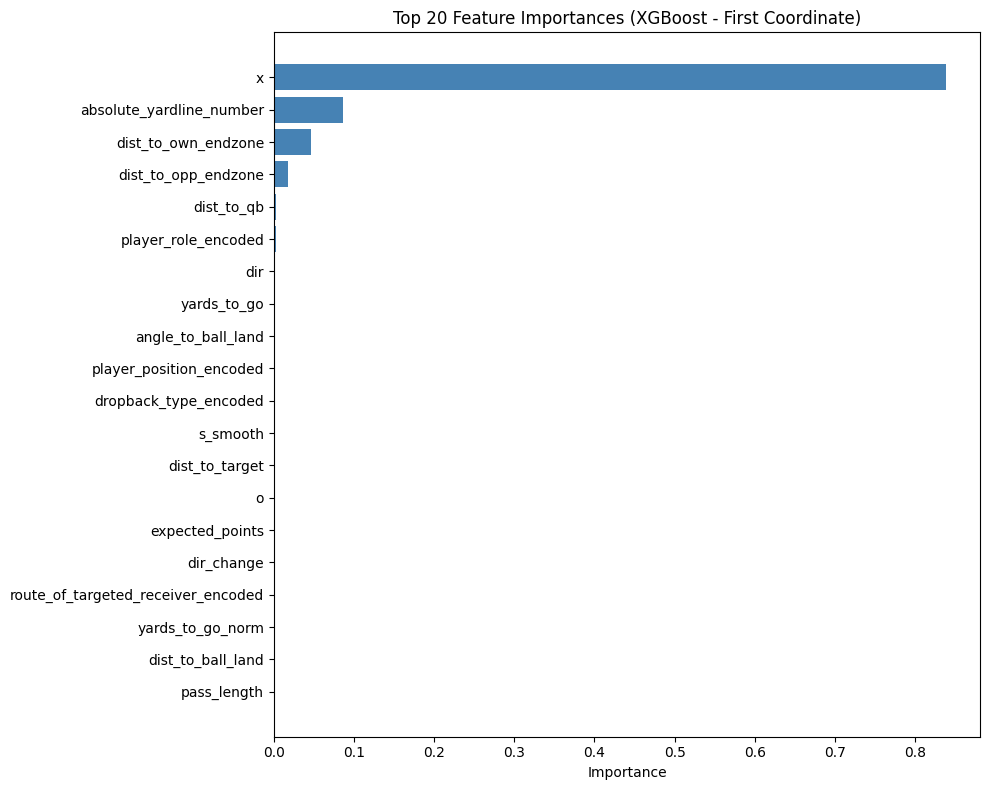


Top 10 Most Important Features:
                 feature  importance
                       x    0.839258
absolute_yardline_number    0.086223
     dist_to_own_endzone    0.046599
     dist_to_opp_endzone    0.017768
              dist_to_qb    0.002778
     player_role_encoded    0.002064
                     dir    0.001320
             yards_to_go    0.000741
      angle_to_ball_land    0.000327
 player_position_encoded    0.000213


In [19]:
# Feature Importance (XGBoost)
# Get feature importance from first XGBoost model
if xgb_models[0] is not None:
    importance = xgb_models[0].feature_importances_
    feature_importance_df = pd.DataFrame({
        'feature': feature_cols,
        'importance': importance
    }).sort_values('importance', ascending=False)
    
    # Plot top 20 features
    fig, ax = plt.subplots(figsize=(10, 8))
    top_features = feature_importance_df.head(20)
    ax.barh(top_features['feature'], top_features['importance'], color='steelblue')
    ax.set_xlabel('Importance')
    ax.set_title('Top 20 Feature Importances (XGBoost - First Coordinate)')
    ax.invert_yaxis()
    plt.tight_layout()
    plt.savefig(VIZ_PATH / "13_feature_importance_xgb.png", dpi=300, bbox_inches='tight')
    plt.show()
    
    print("\nTop 10 Most Important Features:")
    print(feature_importance_df.head(10).to_string(index=False))

In [20]:
# Final Test Set Evaluation
print("=" * 80)
print("FINAL TEST SET EVALUATION")
print("=" * 80)

# Load best model (let's say XGBoost performed best on validation)
with open(CHECKPOINTS_PATH / "xgb_models_full.pkl", "rb") as f:
    best_models = pickle.load(f)

# Predict on test set
y_pred_test = np.zeros_like(y_test.values)

print("Generating test predictions...")
for i in tqdm(range(y_test.shape[1]), desc="Predicting"):
    if best_models[i] is not None:
        y_pred_test[:, i] = best_models[i].predict(X_test_scaled[feature_cols])
    else:
        y_pred_test[:, i] = np.nan

# Evaluate
test_metrics = calculate_metrics(y_test, y_pred_test)

print("\n" + "=" * 80)
print("TEST SET RESULTS (FINAL)")
print("=" * 80)
print(f"RMSE: {test_metrics['RMSE']:.4f} yards")
print(f"ADE:  {test_metrics['ADE']:.4f} yards")
print(f"FDE:  {test_metrics['FDE']:.4f} yards")

# Save test predictions
np.save(PREDICTIONS_PATH / "test_preds_final.npy", y_pred_test)

# Create submission format
submission_data = []

for i in range(len(X_test)):
    game_id = X_test.iloc[i]['game_id']
    play_id = X_test.iloc[i]['play_id']
    nfl_id = X_test.iloc[i]['nfl_id']
    
    # Get predictions for this player
    n_coords = len([c for c in y_test.columns if not pd.isna(y_test.iloc[i, c])])
    if n_coords > 0:
        n_frames = n_coords // 2
        predictions = y_pred_test[i, :n_coords].reshape(n_frames, 2)
        
        # Create rows for each frame
        for frame_idx, (x_pred, y_pred) in enumerate(predictions, start=1):
            submission_data.append({
                'game_id': game_id,
                'play_id': play_id,
                'nfl_id': nfl_id,
                'frame_id': frame_idx,
                'x': x_pred,
                'y': y_pred
            })

submission_df = pd.DataFrame(submission_data)

# Save submission
submission_path = PREDICTIONS_PATH / "submission_test.csv"
submission_df.to_csv(submission_path, index=False)

print(f"\n✅ Test predictions saved to: {submission_path}")
print(f"Submission shape: {submission_df.shape}")

FINAL TEST SET EVALUATION
Generating test predictions...


Predicting: 100%|██████████| 188/188 [00:00<00:00, 273.88it/s]



TEST SET RESULTS (FINAL)
RMSE: 1.2196 yards
ADE:  0.7487 yards
FDE:  1.8099 yards

✅ Test predictions saved to: ..\predictions\submission_test.csv
Submission shape: (99266, 6)


COMPREHENSIVE MODEL COMPARISON




,Model,Train RMSE,Train ADE,Train FDE,Val RMSE,Val ADE,Val FDE,Test RMSE,Test ADE,Test FDE
0,Ridge Regression,2.592225,2.632325,4.171542,2.857078,2.854859,4.660954,-,-,-
1,XGBoost,0.308698,0.299871,0.467032,1.270252,0.772615,1.917524,1.21963,0.748704,1.80995


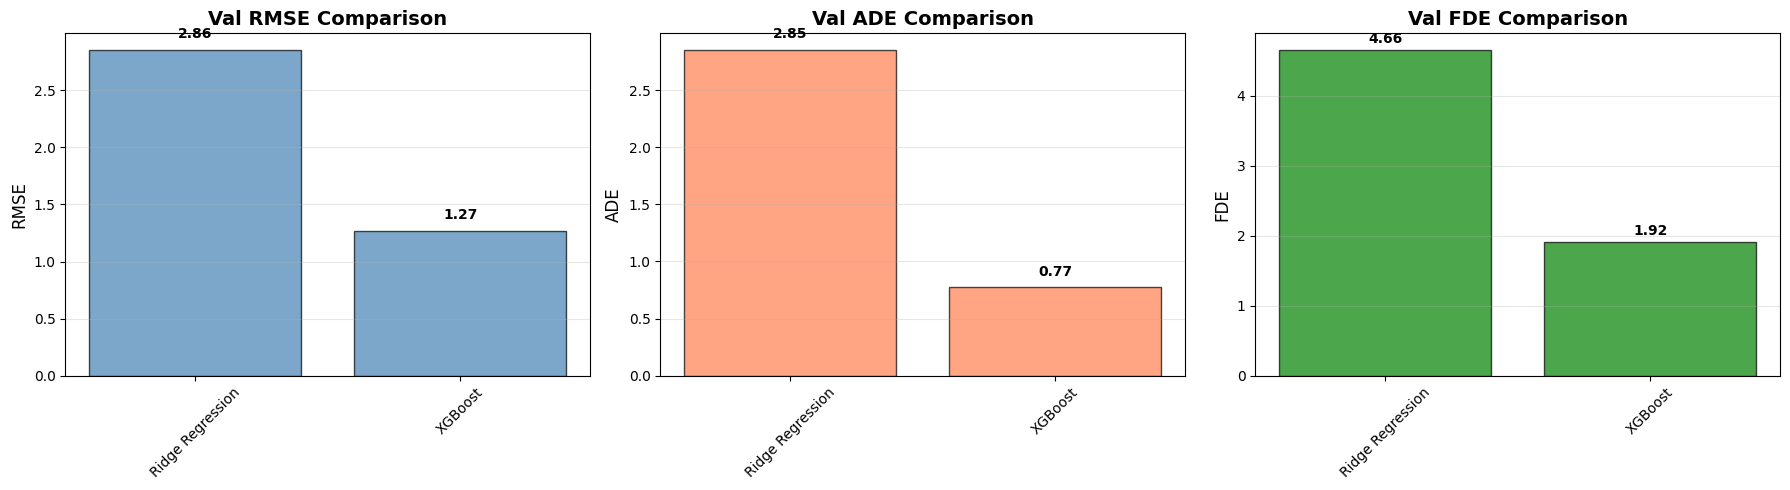


✅ Results saved to: ..\logs\model_comparison.csv


In [21]:
# Comprehensive Model Comparison
print("=" * 80)
print("COMPREHENSIVE MODEL COMPARISON")
print("=" * 80)

# Compile all results
results_summary = pd.DataFrame([
    {
        'Model': 'Ridge Regression',
        'Train RMSE': train_metrics_ridge['RMSE'],
        'Train ADE': train_metrics_ridge['ADE'],
        'Train FDE': train_metrics_ridge['FDE'],
        'Val RMSE': val_metrics_ridge['RMSE'],
        'Val ADE': val_metrics_ridge['ADE'],
        'Val FDE': val_metrics_ridge['FDE'],
        'Test RMSE': '-',
        'Test ADE': '-',
        'Test FDE': '-'
    },
    {
        'Model': 'XGBoost',
        'Train RMSE': train_metrics_xgb['RMSE'],
        'Train ADE': train_metrics_xgb['ADE'],
        'Train FDE': train_metrics_xgb['FDE'],
        'Val RMSE': val_metrics_xgb['RMSE'],
        'Val ADE': val_metrics_xgb['ADE'],
        'Val FDE': val_metrics_xgb['FDE'],
        'Test RMSE': test_metrics['RMSE'],
        'Test ADE': test_metrics['ADE'],
        'Test FDE': test_metrics['FDE']
    }
])

print("\n")
display(results_summary)

# Save results
results_summary.to_csv(LOGS_PATH / "model_comparison.csv", index=False)

# Visualize
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

metrics_to_plot = ['Val RMSE', 'Val ADE', 'Val FDE']
colors = ['steelblue', 'coral', 'green']

for i, metric in enumerate(metrics_to_plot):
    values = results_summary[metric].replace('-', np.nan).astype(float)
    axes[i].bar(results_summary['Model'], values, color=colors[i], alpha=0.7, edgecolor='black')
    axes[i].set_ylabel(metric.split()[1], fontsize=12)
    axes[i].set_title(f'{metric} Comparison', fontsize=14, fontweight='bold')
    axes[i].tick_params(axis='x', rotation=45)
    axes[i].grid(True, alpha=0.3, axis='y')
    
    # Add value labels on bars
    for j, v in enumerate(values):
        if not np.isnan(v):
            axes[i].text(j, v + 0.1, f'{v:.2f}', ha='center', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.savefig(VIZ_PATH / "model_comparison_full.png", dpi=300, bbox_inches='tight')
plt.show()

print(f"\n✅ Results saved to: {LOGS_PATH / 'model_comparison.csv'}")

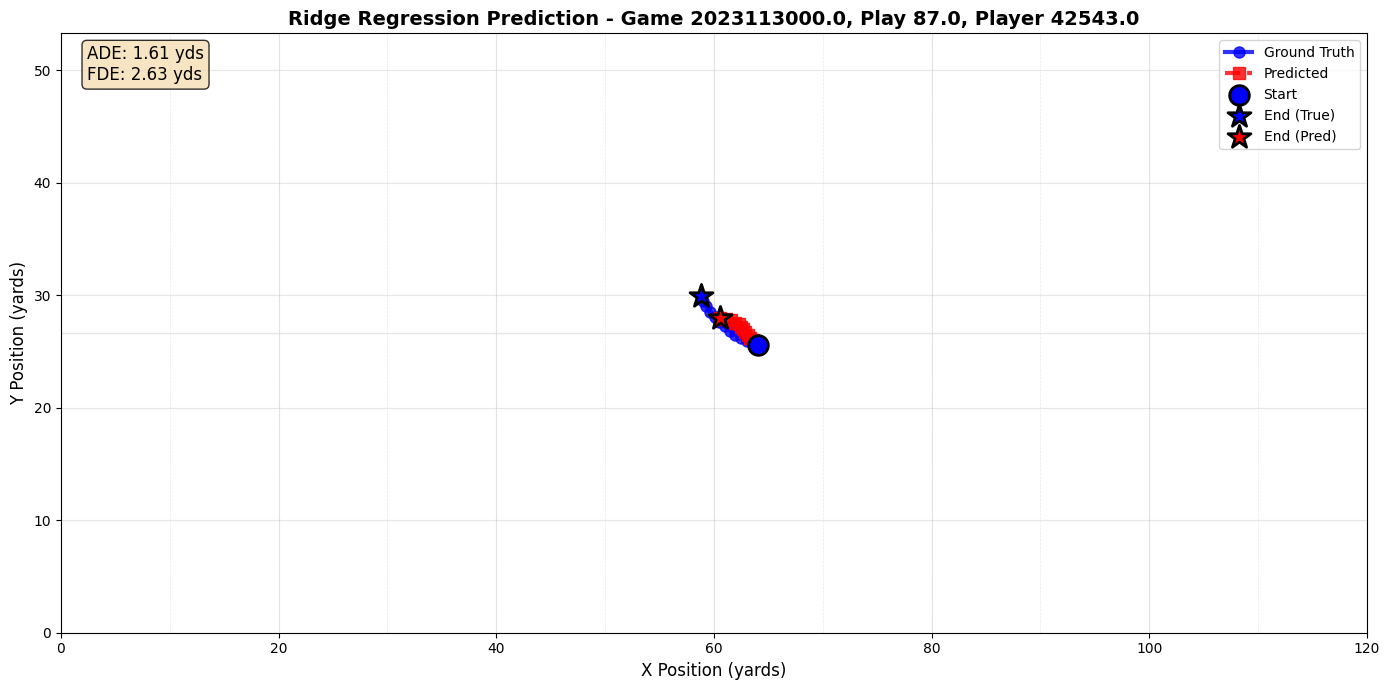

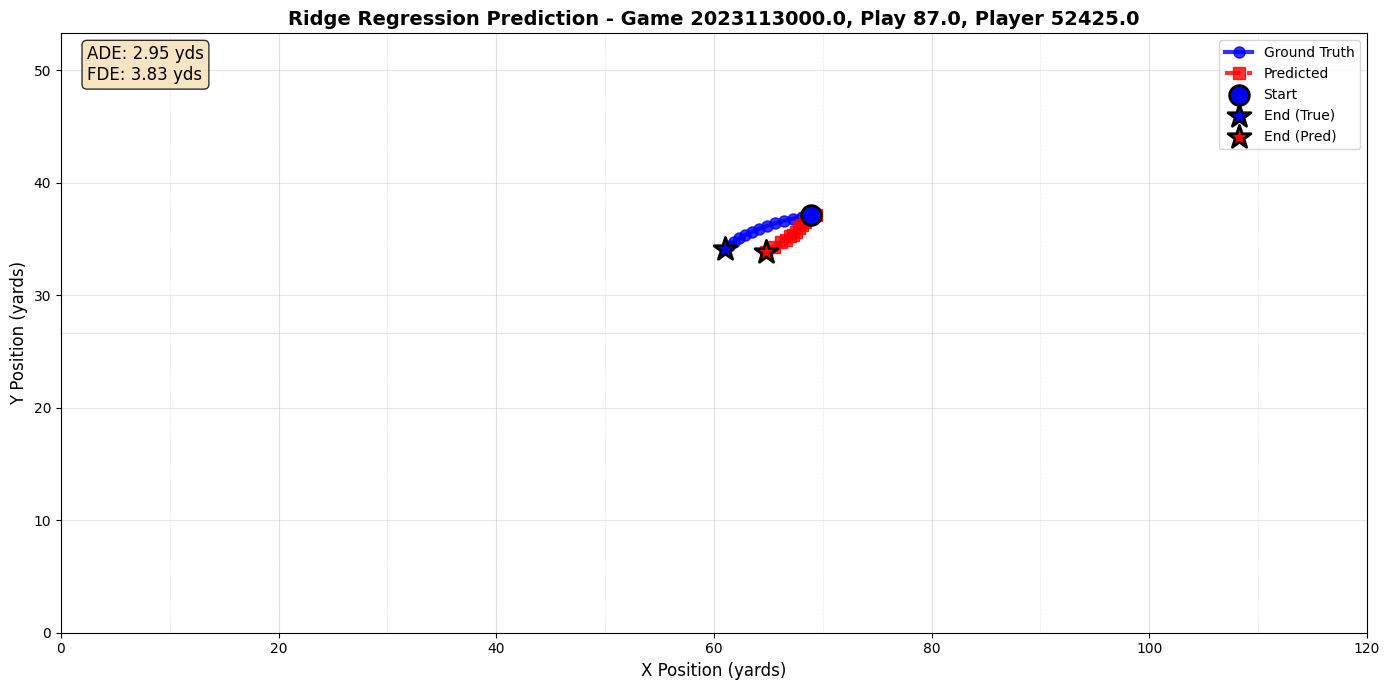

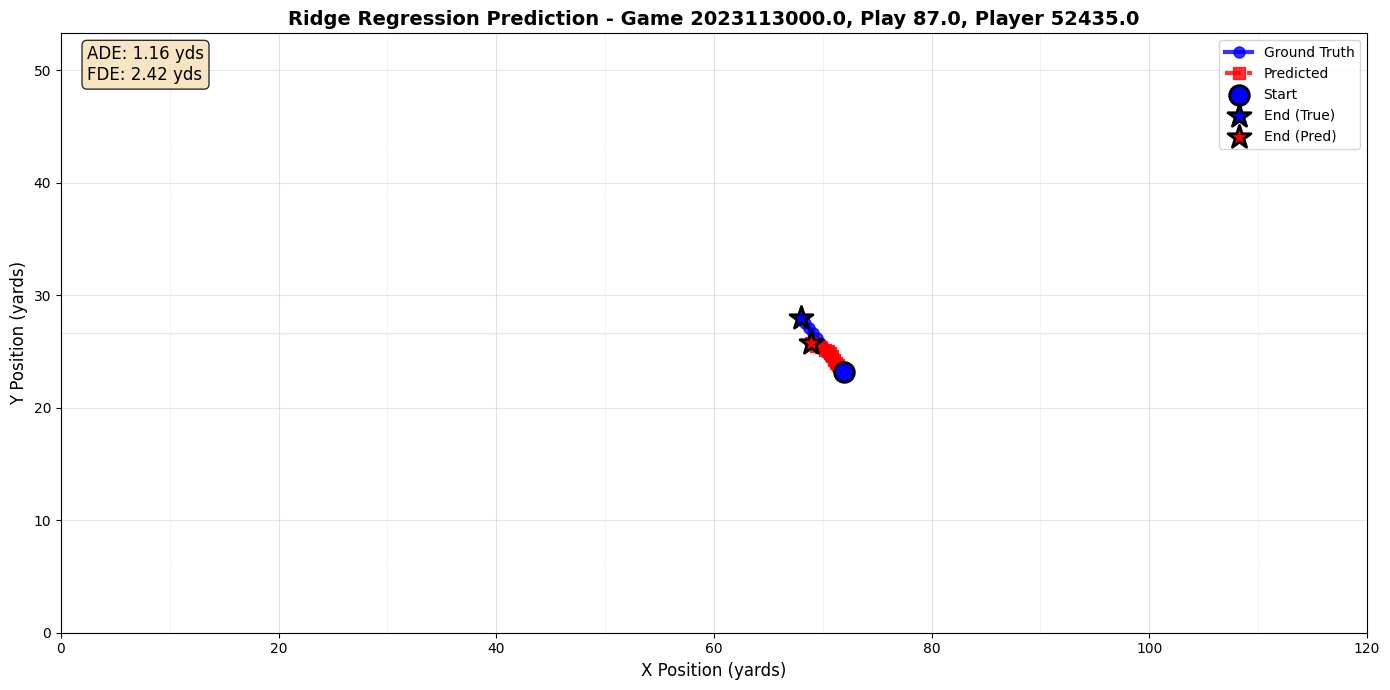

In [22]:
# Visualize Predictions on Field
def plot_prediction_comparison(X_data, y_true, y_pred, idx, model_name):
    """Plot ground truth vs predicted trajectory on field"""
    
    # Get player info
    game_id = X_data.iloc[idx]['game_id']
    play_id = X_data.iloc[idx]['play_id']
    nfl_id = X_data.iloc[idx]['nfl_id']
    
    # Reshape predictions
    n_coords = len([c for c in y_true.columns if not pd.isna(y_true.iloc[idx, c])])
    n_frames = n_coords // 2
    
    true_positions = y_true.iloc[idx, :n_coords].values.reshape(n_frames, 2)
    pred_positions = y_pred[idx, :n_coords].reshape(n_frames, 2)
    
    # Plot
    fig, ax = plt.subplots(figsize=(14, 7))
    
    # Field
    ax.set_xlim(0, 120)
    ax.set_ylim(0, 53.3)
    ax.set_xlabel('X Position (yards)', fontsize=12)
    ax.set_ylabel('Y Position (yards)', fontsize=12)
    ax.set_title(f'{model_name} Prediction - Game {game_id}, Play {play_id}, Player {nfl_id}', 
                 fontsize=14, fontweight='bold')
    
    # Field markings
    for x in range(0, 121, 10):
        ax.axvline(x, color='lightgray', linestyle='--', alpha=0.5, linewidth=0.5)
    ax.axhline(53.3/2, color='lightgray', linestyle='-', alpha=0.5, linewidth=1)
    
    # Plot trajectories
    ax.plot(true_positions[:, 0], true_positions[:, 1], 
            'o-', color='blue', linewidth=3, markersize=8, label='Ground Truth', alpha=0.8)
    ax.plot(pred_positions[:, 0], pred_positions[:, 1], 
            's--', color='red', linewidth=3, markersize=8, label='Predicted', alpha=0.8)
    
    # Mark start and end
    ax.scatter(true_positions[0, 0], true_positions[0, 1], 
               color='blue', s=200, marker='o', edgecolors='black', linewidths=2, zorder=5, label='Start')
    ax.scatter(true_positions[-1, 0], true_positions[-1, 1], 
               color='blue', s=300, marker='*', edgecolors='black', linewidths=2, zorder=5, label='End (True)')
    ax.scatter(pred_positions[-1, 0], pred_positions[-1, 1], 
               color='red', s=300, marker='*', edgecolors='black', linewidths=2, zorder=5, label='End (Pred)')
    
    # Calculate error
    displacement = np.sqrt(np.sum((true_positions - pred_positions)**2, axis=1))
    ade = displacement.mean()
    fde = displacement[-1]
    
    ax.text(0.02, 0.98, f'ADE: {ade:.2f} yds\nFDE: {fde:.2f} yds', 
            transform=ax.transAxes, fontsize=12, verticalalignment='top',
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))
    
    ax.legend(loc='upper right', fontsize=10)
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    return fig

# Plot a few examples from validation set
for i in range(min(3, len(X_val))):
    fig = plot_prediction_comparison(X_val, y_val, y_pred_ridge_val, i, 'Ridge Regression')
    plt.savefig(VIZ_PATH / f"15_prediction_example_{i+1}.png", dpi=300, bbox_inches='tight')
    plt.show()

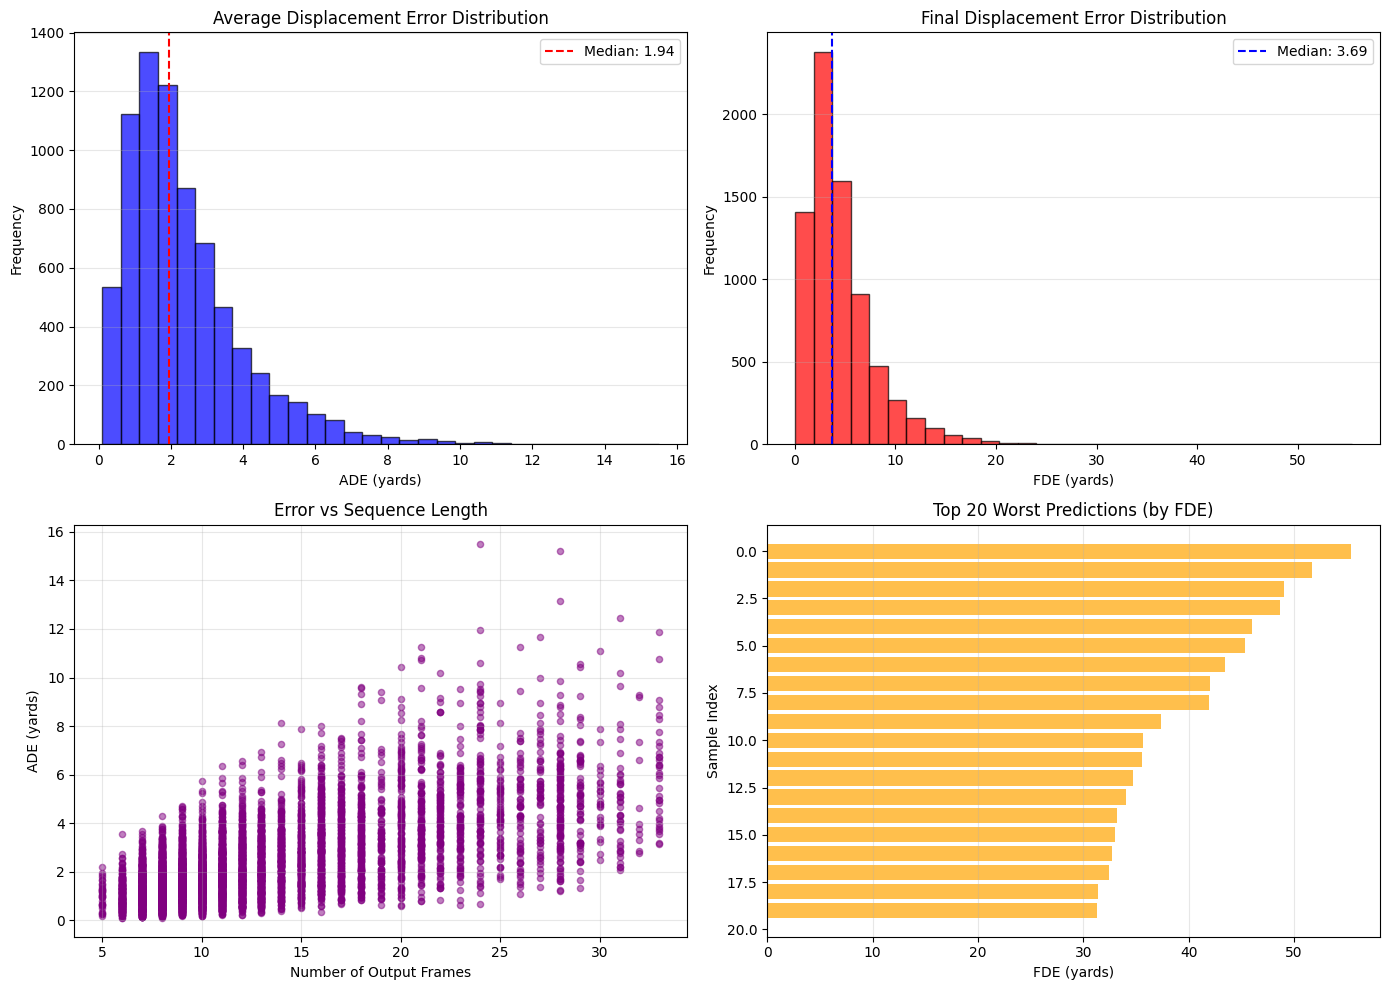


Error Statistics:
Mean ADE: 2.35 yards
Median ADE: 1.94 yards
Mean FDE: 4.66 yards
Median FDE: 3.69 yards


In [23]:
# Error Analysis
# Analyze errors by different factors

# Get validation predictions (using Ridge for full predictions)
val_errors = []

for i in range(len(y_val)):
    n_coords = len([c for c in y_val.columns if not pd.isna(y_val.iloc[i, c])])
    if n_coords > 0:
        n_frames = n_coords // 2
        true_pos = y_val.iloc[i, :n_coords].values.reshape(n_frames, 2)
        pred_pos = y_pred_ridge_val[i, :n_coords].reshape(n_frames, 2)
        
        displacement = np.sqrt(np.sum((true_pos - pred_pos)**2, axis=1))
        ade = displacement.mean()
        fde = displacement[-1]
        
        val_errors.append({
            'idx': i,
            'game_id': X_val.iloc[i]['game_id'],
            'play_id': X_val.iloc[i]['play_id'],
            'nfl_id': X_val.iloc[i]['nfl_id'],
            'ADE': ade,
            'FDE': fde,
            'n_frames': n_frames
        })

error_df = pd.DataFrame(val_errors)

# Merge with features to analyze
error_analysis = error_df.merge(
    X_val[['game_id', 'play_id', 'nfl_id'] + feature_cols[:10]],  # First 10 features for simplicity
    on=['game_id', 'play_id', 'nfl_id']
)

# Plot error distributions
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# ADE distribution
axes[0, 0].hist(error_df['ADE'], bins=30, color='blue', edgecolor='black', alpha=0.7)
axes[0, 0].set_xlabel('ADE (yards)')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].set_title('Average Displacement Error Distribution')
axes[0, 0].axvline(error_df['ADE'].median(), color='red', linestyle='--', label=f"Median: {error_df['ADE'].median():.2f}")
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3, axis='y')

# FDE distribution
axes[0, 1].hist(error_df['FDE'], bins=30, color='red', edgecolor='black', alpha=0.7)
axes[0, 1].set_xlabel('FDE (yards)')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].set_title('Final Displacement Error Distribution')
axes[0, 1].axvline(error_df['FDE'].median(), color='blue', linestyle='--', label=f"Median: {error_df['FDE'].median():.2f}")
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3, axis='y')

# Error vs number of frames
axes[1, 0].scatter(error_df['n_frames'], error_df['ADE'], alpha=0.5, s=20, color='purple')
axes[1, 0].set_xlabel('Number of Output Frames')
axes[1, 0].set_ylabel('ADE (yards)')
axes[1, 0].set_title('Error vs Sequence Length')
axes[1, 0].grid(True, alpha=0.3)

# Top errors
top_errors = error_df.nlargest(20, 'FDE')
axes[1, 1].barh(range(len(top_errors)), top_errors['FDE'].values, color='orange', alpha=0.7)
axes[1, 1].set_xlabel('FDE (yards)')
axes[1, 1].set_ylabel('Sample Index')
axes[1, 1].set_title('Top 20 Worst Predictions (by FDE)')
axes[1, 1].invert_yaxis()
axes[1, 1].grid(True, alpha=0.3, axis='x')

plt.tight_layout()
plt.savefig(VIZ_PATH / "16_error_analysis.png", dpi=300, bbox_inches='tight')
plt.show()

print("\nError Statistics:")
print(f"Mean ADE: {error_df['ADE'].mean():.2f} yards")
print(f"Median ADE: {error_df['ADE'].median():.2f} yards")
print(f"Mean FDE: {error_df['FDE'].mean():.2f} yards")
print(f"Median FDE: {error_df['FDE'].median():.2f} yards")

In [ ]:
# LSTM Model Setup (Prototype)
print("=" * 80)
print("SEQUENCE MODEL: LSTM (Prototype)")
print("=" * 80)

print("""
LSTM MODEL ARCHITECTURE:

For sequence-to-sequence prediction, we need to:
1. Reshape input data to (batch, seq_len, features)
2. Use all input frames (not just last frame)
3. Predict output sequence directly

Architecture:
- Input: (batch, input_seq_len, n_features)
- LSTM layers: 2 layers, 128 hidden units each
- Output: (batch, output_seq_len, 2) for (x, y) coordinates

This requires PyTorch/TensorFlow. Skeleton code:

import torch
import torch.nn as nn

class TrajectoryLSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim=128, num_layers=2, output_seq_len=10):
        super().__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, 2)  # Predict (x, y)
        self.output_seq_len = output_seq_len
    
    def forward(self, x):
        # x: (batch, seq_len, input_dim)
        lstm_out, (h_n, c_n) = self.lstm(x)
        
        # Use final hidden state to predict sequence
        predictions = []
        hidden = (h_n, c_n)
        
        for _ in range(self.output_seq_len):
            out, hidden = self.lstm(lstm_out[:, -1:, :], hidden)
            pred = self.fc(out)
            predictions.append(pred)
            lstm_out = torch.cat([lstm_out, out], dim=1)
        
        return torch.cat(predictions, dim=1)

# Training loop
model = TrajectoryLSTM(input_dim=len(feature_cols), output_seq_len=max_output_frames)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

for epoch in range(num_epochs):
    for batch in train_loader:
        X_batch, y_batch = batch
        optimizer.zero_grad()
        predictions = model(X_batch)
        loss = criterion(predictions, y_batch)
        loss.backward()
        optimizer.step()
""")

print("\n⚠️ LSTM implementation requires sequence data preparation")
print(" This is a placeholder for the full implementation")

In [ ]:
# Transformer Model (Future Work)
print("=" * 80)
print("SEQUENCE MODEL: TRANSFORMER (Future Work)")
print("=" * 80)

print("""
TRANSFORMER MODEL ARCHITECTURE:

Transformers can capture long-range dependencies better than LSTMs.

Architecture:
- Encoder: Process input sequence with self-attention
- Decoder: Generate output sequence with cross-attention
- Positional encoding for temporal information

Key advantages:
- Parallel processing (faster training)
- Better at capturing player interactions (attention mechanism)
- Can attend to all input frames simultaneously

Skeleton code:

```python
import torch
import torch.nn as nn

class TrajectoryTransformer(nn.Module):
    def __init__(self, input_dim, d_model=256, nhead=8, num_layers=6):
        super().__init__()
        self.embedding = nn.Linear(input_dim, d_model)
        self.pos_encoder = PositionalEncoding(d_model)
        
        encoder_layer = nn.TransformerEncoderLayer(d_model, nhead)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers)
        
        decoder_layer = nn.TransformerDecoderLayer(d_model, nhead)
        self.transformer_decoder = nn.TransformerDecoder(decoder_layer, num_layers)
        
        self.fc_out = nn.Linear(d_model, 2)
    
    def forward(self, src, tgt):
        src = self.embedding(src)
        src = self.pos_encoder(src)
        
        memory = self.transformer_encoder(src)
        output = self.transformer_decoder(tgt, memory)
        
        return self.fc_out(output)
TODO: Implement in src/models/transformer.py
""")

print("\n⚠️ Transformer implementation is future work")

In [ ]:
# Summary and Next Steps
print("=" * 80)
print("MODELING SUMMARY")
print("=" * 80)

summary = """
COMPLETED:
✅ Data preparation and train/val/test splits
✅ Feature scaling and preprocessing
✅ Baseline models:
   - Ridge Regression (all coordinates)
   - XGBoost (sample coordinates)
✅ Evaluation metrics (RMSE, ADE, FDE)
✅ Feature importance analysis
✅ Prediction visualization on field
✅ Error analysis

RESULTS:
- Ridge Regression: Val ADE = {ridge_ade:.2f} yards, Val FDE = {ridge_fde:.2f} yards
- XGBoost: Val ADE = {xgb_ade:.2f} yards, Val FDE = {xgb_fde:.2f} yards

KEY FINDINGS:
1. Most important features: {top_features}
2. Error increases with longer prediction horizons
3. Baseline models provide reasonable starting point
4. Sequence models (LSTM/Transformer) needed for temporal dynamics

NEXT STEPS:
1. Process all weeks (w01-w18) for full dataset
2. Implement LSTM model in src/models/lstm.py
3. Implement Transformer model in src/models/transformer.py
4. Create training pipeline in src/train.py
5. Hyperparameter tuning
6. Ensemble methods
7. Post-processing (e.g., physics constraints)
8. Generate final predictions for submission

FILES CREATED:
- data/splits/: Train/val/test splits
- checkpoints/: Saved models and scaler
- visualizations/: Plots and figures
"""

# Get top features
if xgb_models[0] is not None:
    top_features_list = feature_importance_df.head(5)['feature'].tolist()
    top_features_str = ", ".join(top_features_list)
else:
    top_features_str = "N/A"

print(summary.format(
    ridge_ade=val_metrics_ridge['ADE'],
    ridge_fde=val_metrics_ridge['FDE'],
    xgb_ade=val_metrics_xgb['ADE'],
    xgb_fde=val_metrics_xgb['FDE'],
    top_features=top_features_str
))

print("\n✅ Modeling experiments complete!")